# Logistic Regression

### Import necessary packages

In [1]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import pandas as pd

import mlflow
import logging 
import config 

from basic_functions import (
    get_preprocess_data,
    get_lemmatized_data,
    get_metrics
)


/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup

In [2]:
MODEL_NAME = "logistic_regression" 
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [3]:
DATA_PATH = "../data/data_dropped_duplicates_small.csv"


In [4]:
# mlflow.set_tracking_uri(TRACKING_URI)
# mlflow.set_experiment(EXPERIMENT_NAME)
# mlflow.start_run()
# run = mlflow.active_run()
# mlflow.set_tag("model_name", MODEL_NAME)
# mlflow.set_tag("mlflow.runName", "logistic_regression")
# mlflow.log_params(params)

### Get and process data

In [5]:
df = get_preprocess_data(DATA_PATH)

In [6]:
def binary_classification(x):
    if x == 'none':
        return 'none'
    else:
        return 'fallacy'

In [7]:
df_binary = df.copy()
df_binary['two_class_target'] = df_binary['logical_fallacies'].apply(binary_classification)

In [8]:
df_multi_class = df.copy()
df_multi_class = df_multi_class[df_multi_class["logical_fallacies"] != 'none']

In [9]:
# nltk.download('wordnet') commented because downloaded once.

### Lemmatize text

In [10]:
df_binary = get_lemmatized_data(df_binary)
df_multi_class = get_lemmatized_data(df_multi_class)

### Train-test split

In [11]:
y_binary = df_binary[["two_class_target", "logical_fallacies"]]
X_binary = df_binary["text"]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_binary, y_binary, test_size=0.30, random_state=42, stratify=y_binary)

In [12]:
fa_train = y_train_b["logical_fallacies"]
y_train_b = y_train_b["two_class_target"]

In [13]:
fa_test = y_test_b["logical_fallacies"]
y_test_b = y_test_b["two_class_target"]

In [14]:
y_multi = df_multi_class["logical_fallacies"]
X_multi = df_multi_class["text"]

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.30, random_state=42, stratify=y_multi)

### Logistic Regression

#### thoughts for the moment

- pipeline one: binary first, classification next 
- pipeline 2: classification from the get-go
- add stemming? Not now, since we have the lemmatization
- add bag of words? not now
- For a multi_class problem, 
    - multi_class = “multinomial” 
- class weigh = balanced

In [15]:
# Use TF-IDF Vecorizer to transform text into numerical data
tfidf_vectorizer = TfidfVectorizer()
X_vectorized_b = tfidf_vectorizer.fit_transform(X_train_b)
X_vectorized_test_b = tfidf_vectorizer.transform(X_test_b)

In [16]:
# for the multi calss
tfidf_vectorizer_m = TfidfVectorizer()
X_vectorized_m = tfidf_vectorizer_m.fit_transform(X_train_m)
X_vectorized_test_m = tfidf_vectorizer_m.transform(X_test_m)

### Initialize the model

#### Binary classification

In [16]:
bin_model = LogisticRegression(
    penalty='l2',  # most of the solvers only work with l2
    random_state=42, 
    verbose=0, 
    n_jobs=-1, 
    )

In [17]:
# Grid search for binary classification
param_grid_bin = {
'C': [0.1, 1, 10, 100],
'max_iter': [100, 500, 1000],
'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
}

In [ ]:
grid_search_b = GridSearchCV(bin_model, param_grid_bin, cv=5)
grid_search_b.fit(X_vectorized_b, y_train_b)

best_params_b = grid_search_b.best_params_
print(best_params_b)

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/maren/Library/CloudStorage/OneDrive-Persö

In [20]:

# Predict on train and test data
best_model_b = grid_search_b.best_estimator_
y_train_pred_b = best_model_b.predict(X_vectorized_b)
y_test_pred_b = best_model_b.predict(X_vectorized_test_b)

# mlflow.log_params(best_params_b)

#### Multi-class classification

In [21]:
multi_model = LogisticRegression(
    penalty='l2',  # most of the solvers only work with l2
    class_weight= "balanced", 
    random_state=42, 
    multi_class='multinomial', 
    verbose=0, 
    n_jobs=-1, 
    )

In [22]:

# Grid search
param_grid_multi = {
'C': [0.1, 1, 10, 100],
'max_iter': [100, 500, 1000],
'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
}

In [23]:
grid_search_m = GridSearchCV(multi_model, param_grid_multi, cv=5)
grid_search_m.fit(X_vectorized_m, y_train_m)

best_params_m = grid_search_m.best_params_
print(best_params_m)

/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproces

{'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}


/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:

# Predict on train and test data
best_model_m = grid_search_m.best_estimator_
y_train_pred_m = best_model_m.predict(X_vectorized_m)

# mlflow.log_params(best_params_b)

In [25]:
# # Save model to pickle file:
# with open('../models/svm/svm_model.pkl', 'wb') as f:
#     pickle.dump(best_model, f)

#### Two-step approach

In [26]:
df_pred =  pd.DataFrame({"text": X_test_b, "logical_fallacies": fa_test , "two_class_target": y_test_b, "binary_prediction": y_test_pred_b})
df_pred.head()

,text,logical_fallacies,two_class_target,binary_prediction
17769,nuclear power is too dangerous,none,none,fallacy
11994,how disturbing and sad this story truly is i k...,none,none,none
8523,i see the situation a more complex than that i...,none,none,none
9975,how doe the country just let so many dangerous...,faulty_generalization,fallacy,fallacy
19573,he twisted arm and got six democrat to vote th...,appeal_to_emotion,fallacy,fallacy


In [27]:
df_pred = df_pred[df_pred["binary_prediction"] != "none"]

In [28]:
X_df_pred = tfidf_vectorizer_m.transform(df_pred["text"])
X_df_pred

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15701 stored elements and shape (758, 6333)>

In [29]:
y_test_pred_m = best_model_m.predict(X_df_pred)


### Evaluation


In [30]:
# def log_metrics(cr, split):
#     for key, value in cr.items():
#         if (key == "accuracy"):
#                 # print(f"{split}_{key}", round(value,2))
#                 mlflow.log_metric(f"{split}_{key}", value)
#         else:
#             for metric in value:
#                 mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
#                 # print(f"{split}_{key}_{metric}", round(value.get(metri

In [15]:
logger.info('get test metrics for the two step approach')
classification_report_test = get_metrics(df_pred["logical_fallacies"], y_test_pred_m)
# log_metrics(classification_report_test, "test")

INFO:root:get test metrics for the two step approach


NameError: name 'df_pred' is not defined

In [32]:
logger.info('get train metrics for binary classification')
classification_report_b_train = get_metrics(y_train_b, y_train_pred_b)
# log_metrics(classification_report_b_train, "train")

INFO:root:get train metrics for binary classification
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix


              precision    recall  f1-score   support

     fallacy       0.88      0.88      0.88      1785
        none       0.87      0.88      0.88      1715

    accuracy                           0.88      3500
   macro avg       0.88      0.88      0.88      3500
weighted avg       0.88      0.88      0.88      3500

[[1563  222]
 [ 207 1508]]


In [33]:
logger.info('get train metrics for multi classification')
classification_report_m_train = get_metrics(y_train_m, y_train_pred_m)
# log_metrics(classification_report_m_train, "train")

INFO:root:get train metrics for multi classification
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix


                       precision    recall  f1-score   support

           ad_hominem       0.99      1.00      1.00       326
  appeal_to_authority       1.00      1.00      1.00       229
    appeal_to_emotion       1.00      1.00      1.00       486
        false_dilemma       1.00      1.00      1.00       299
faulty_generalization       1.00      1.00      1.00       445

             accuracy                           1.00      1785
            macro avg       1.00      1.00      1.00      1785
         weighted avg       1.00      1.00      1.00      1785

[[326   0   0   0   0]
 [  0 229   0   0   0]
 [  2   0 484   0   0]
 [  0   0   0 299   0]
 [  0   0   0   1 444]]


In [34]:
# mlflow.end_run()

### One step approach


In [17]:
df = get_preprocess_data(DATA_PATH)
df = get_lemmatized_data(df)

X = df['text']
y = df['logical_fallacies']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer()
X_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_vectorized_test = tfidf_vectorizer.transform(X_test)

one_model = LogisticRegression(
    penalty='l2',  # most of the solvers only work with l2
    random_state=42,
    class_weight='balanced', 
    verbose=0, 
    n_jobs=-1, 
    )

param_grid_one = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
}

grid_search_one = GridSearchCV(one_model, param_grid_one, cv=5)
grid_search_one.fit(X_vectorized, y_train)

best_params_one = grid_search_one.best_params_
print(best_params_one)

best_model_one = grid_search_one.best_estimator_
y_train_pred_one = best_model_one.predict(X_vectorized)
y_test_pred_one = best_model_one.predict(X_vectorized_test)

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/maren/Library/CloudStorage/OneDrive-Persö

{'C': 1, 'max_iter': 100, 'solver': 'liblinear'}


/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


INFO:root:get train metrics for one-step approach
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix


                       precision    recall  f1-score   support

           ad_hominem       0.80      0.89      0.84       325
  appeal_to_authority       0.88      0.90      0.89       229
    appeal_to_emotion       0.83      0.83      0.83       487
        false_dilemma       0.87      0.86      0.87       299
faulty_generalization       0.88      0.72      0.79       445
                 none       0.89      0.91      0.90      1715

             accuracy                           0.87      3500
            macro avg       0.86      0.85      0.85      3500
         weighted avg       0.87      0.87      0.87      3500

[[ 289    5    7    2    2   20]
 [   2  205    5    1    0   16]
 [  20    7  402    8   11   39]
 [   2    0    4  258    2   33]
 [   8    2   13    9  320   93]
 [  42   13   56   18   28 1558]]


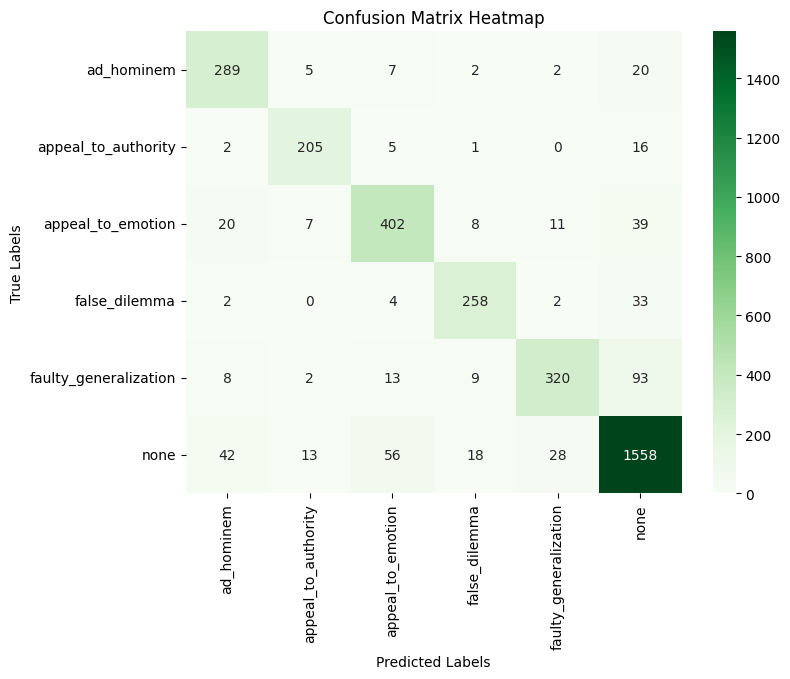

Confusion Matrix Heatmap


In [18]:
logger.info('get train metrics for one-step approach')
classification_report_one_train = get_metrics(y_train, y_train_pred_one)

INFO:root:get test metrics for one-step approach
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix


                       precision    recall  f1-score   support

           ad_hominem       0.53      0.55      0.54       140
  appeal_to_authority       0.47      0.45      0.46        98
    appeal_to_emotion       0.52      0.54      0.53       208
        false_dilemma       0.64      0.60      0.62       128
faulty_generalization       0.57      0.33      0.42       191
                 none       0.74      0.82      0.78       735

             accuracy                           0.65      1500
            macro avg       0.58      0.55      0.56      1500
         weighted avg       0.64      0.65      0.64      1500

[[ 77  12  17   7   5  22]
 [  4  44  10   0   4  36]
 [ 20  14 112   5  16  41]
 [  3   0  11  77   1  36]
 [ 14   7  19   7  63  81]
 [ 26  16  45  25  21 602]]


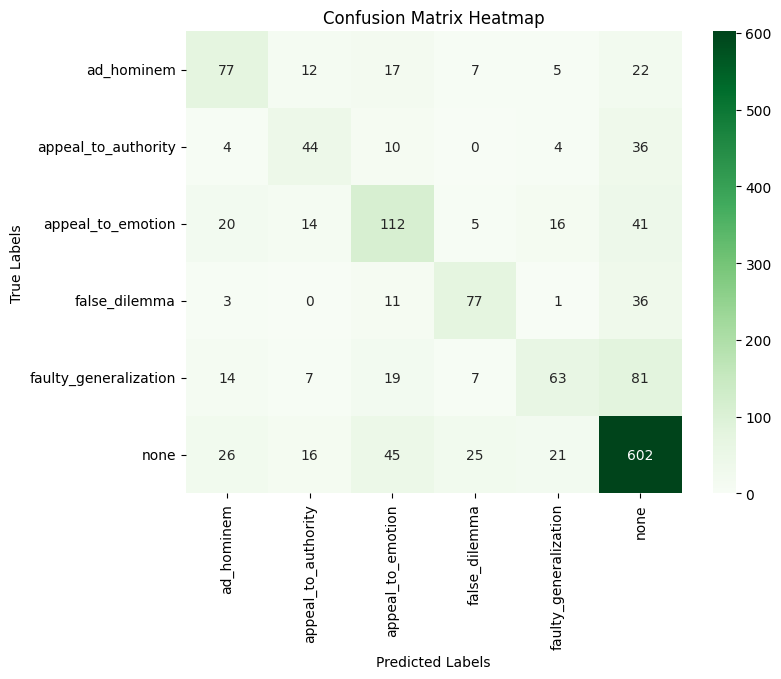

Confusion Matrix Heatmap


In [19]:
logger.info('get test metrics for one-step approach')
classification_report_one_test = get_metrics(y_test, y_test_pred_one)